<a href="https://colab.research.google.com/github/vosjo/sdb_manual/blob/master/SatelliteImageryProcessing_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Imagery Processing with Python - Demonstration

Vojtěch Kusý <kusy@spaceknow.com>, Matěj Bartoš <bartos@spaceknow.com>

This is a demonstration notebook for the presentation *Satellite Imagery Processing with Python, PyCon SK, 2022, Bratislava.*


URL: https://bit.ly/satellite-nb

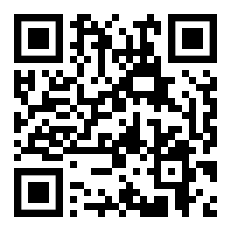

Feel free to clone and execute, and tweak this notebook! 🤠 However, before you attempt to execute the notebook, please go into **Authentication to Earth Engine** section and configure the authentication.

# Setup

In [ ]:
# Install required packages
!pip install rasterio pyproj shapely pandas folium google-colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 26.6 MB/s 
     |████████████████████████████████| 1.6 MB 51.6 MB/s 


In [ ]:
# Folium package provides a map widget.
import folium

def setup_folium(location, zoom=None, width=None, height=None):
  # Using folium.Figure instead of just folium.Map allows better control over
  # the map width and height.
  fig = folium.Figure(width=width, height=height)
  map = folium.Map(location=location, zoom_start=zoom)
  map.add_to(fig)
  return fig, map

# Authentication to Earth Engine

If you want to experiment with the API and execute this notebook. Please set up the `KEY` in the cells above before executing this one.

## Subscribe to Earth Engine API

To execute this notebook, you'll need the following things to use the Earth Engine API:

1. Google cloud account
2. Earth Engine non-commercial subscription
3. Google cloud project with Earth Engine API enabled
4. Google service account with Earth Engine permission
5. Registration of the service account in Earth Engine

The Earth Engine non-commercial subscription can be obtained here: https://earthengine.google.com/. Just click on Sign Up. (Use your private account in case you are working for a company.)

Then [create a project](https://console.cloud.google.com/projectcreate) in a Google Cloud Console and [enable the Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com/overview) within that project.

Then create [the service account](https://console.cloud.google.com/iam-admin/serviceaccounts) with Earth Engine API permissions you'll need to connect this notebook to Earth Engine.

As a last step [register the service account](https://signup.earthengine.google.com/#!/service_accounts) in the Earth Engine. 

## A. Temporary service account key stored at Colab instance

The service account private KEY will be stored at the Colab instance and removed once the instance will be disconnected.

Before execution set the google cloud project ID as `PROJECT` and service account email address as `SERVICE_ACCOUNT`. You can obtain both identifiers at [GCP service accounts page](https://console.cloud.google.com/iam-admin/serviceaccounts).

In [ ]:
# KEY = 'private-key.json'
# PROJECT = 'YOUR_PROJECT'
# SERVICE_ACCOUNT='YOUR_SERVICE@YOUR_PROJECT.iam.gserviceaccount.com'
# !gcloud auth login --project {PROJECT}
# !gcloud iam service-accounts keys create {KEY} --iam-account {SERVICE_ACCOUNT}

## B. Permanent service account key stored at Google Drive

If you want to store the service account private key in Google Drive then you have to [download the private key](https://console.cloud.google.com/iam-admin/serviceaccounts) in the context of your private Google Cloud project and upload it to Google Drive.

TIP: You can execute the cell below without valid KEY first to connect to Google Drive, afterwards you'll be able to upload the file in the File explorer sidebar and also copy the file path to KEY.

Set the KEY to the path at your Google Drive, e.g.: `/content/drive/MyDrive/Colab Notebooks/MyNotebookFolder/private-key.json`

Execute the cell below with a proper path to the service account key.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# KEY = '/content/drive/MyDrive/Colab Notebooks/EarthEngine/private-key.json'

Mounted at /content/drive


## Authenticate to Earth Engine

Once you setup the `KEY` by using the method A or B above you can try to authenticate.

In [ ]:
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(KEY)
scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])
session = AuthorizedSession(scoped_credentials)


# Earth Engine REST API

We are going to use the Earth Engine REST API v1. [Documentation](https://developers.google.com/earth-engine/reference).

These quota limits apply:

> Individual requests for pixel data are also limited to 16MB in uncompressed data per request, ... Requests are also limited to at most 10000 pixels in either dimension and at most 100 bands.


In [ ]:
import json

EE_API = 'https://earthengine.googleapis.com/v1'
EE_PUBLIC = f'{EE_API}/projects/earthengine-public'

# Let's define a point of interest

We define the point as a GeoJSON geometry.

In [ ]:
AOI_JSON = {
  "type": "Point",
  "coordinates": [17.073, 48.152]  # longitude, latitude
}

In [ ]:
# GeoJSON coordinates are longitude and latitude, but folium accepts latitude 
# first and longitude second.
MAP_CENTER = list(reversed(AOI_JSON['coordinates']))
print('POI coordinates (lon, lat):', AOI_JSON['coordinates'])
print('Map center (lat, lon):', MAP_CENTER)

# Display the point on the map
folium_fig, folium_map = setup_folium(location=MAP_CENTER, zoom=15, width=300, height=300)
folium.Marker(MAP_CENTER, popup='FIIT STU').add_to(folium_map)
folium_fig

POI coordinates (lon, lat): [17.073, 48.152]
Map center (lat, lon): [48.152, 17.073]


# Search for the available images in catalog

Once we have the geometry (either a point, rectangle, or any kind of polygon) we can search through the catalog to get the available image data. Usually, we are not interested in all the images which intersect with the geometry. The most common image properties to filter are:
1. Dataset
2. Intersection with AOI
3. Time period when the image was captured
4. Cloud coverage (not needed in radar datasets)

In [ ]:
# Construct the filter
max_cloud_cover_pct = 30  # use 20-30 to select reasonably low cloud coverage
filters = [
    'startTime > "2022-07-01T00:00:00.000Z"',
    'endTime < "2022-09-01T00:00:00.000Z"',
    f'properties.CLOUDY_PIXEL_PERCENTAGE < {max_cloud_cover_pct}',
    f'intersects({json.dumps(json.dumps(AOI_JSON))})',
]
print('Filters:', *filters, sep='\n - ')

# Send the API request
query = {'filter': ' AND '.join(filters)}
url = f'{EE_PUBLIC}/assets/COPERNICUS/S2:listAssets'
response = session.get(url, params=query)
assets = response.json()

# List the filtered assets
print('Found image assets:')
cloud_covers = []
for asset in assets['assets']:
    id = asset['id']
    cloud_cover = asset['properties']['CLOUDY_PIXEL_PERCENTAGE']
    cloud_covers.append(cloud_cover)
    start_time = asset['startTime']
    print(f'{id} | {start_time} | {cloud_cover}')

Filters:
 - startTime > "2022-07-01T00:00:00.000Z"
 - endTime < "2022-09-01T00:00:00.000Z"
 - properties.CLOUDY_PIXEL_PERCENTAGE < 30
 - intersects("{\"type\": \"Point\", \"coordinates\": [17.073, 48.152]}")
Found image assets:
COPERNICUS/S2/20220701T095041_20220701T095042_T33UXP | 2022-07-01T09:57:32.055Z | 8.6786407477082
COPERNICUS/S2/20220706T095039_20220706T095034_T33UXP | 2022-07-06T09:57:24.076Z | 21.7505449550599
COPERNICUS/S2/20220714T100041_20220714T100046_T33UXP | 2022-07-14T10:07:27.895Z | 1.70581786926582
COPERNICUS/S2/20220716T094549_20220716T094815_T33UXP | 2022-07-16T09:57:23.648Z | 14.1953775866702
COPERNICUS/S2/20220719T095559_20220719T095747_T33UXP | 2022-07-19T10:07:20.208Z | 0.00945171246126373
COPERNICUS/S2/20220721T095041_20220721T095041_T33UXP | 2022-07-21T09:57:30.366Z | 0
COPERNICUS/S2/20220724T100041_20220724T100037_T33UXP | 2022-07-24T10:07:25.859Z | 1.5418439893336
COPERNICUS/S2/20220803T100041_20220803T100037_T33UXP | 2022-08-03T10:07:25.941Z | 3.159508932

Notice how much cloud cover we get even during summer. Also notice how often is our AOI revisited by the satellite. To get an idea how the imagery look like, you can also try to do filtering in [Cloudless Sentinel S2 Earth Engine app](https://showcase.earthengine.app/view/s2-sr-browser-s2cloudless-nb) which offers nice preview and filtering features.

# Inspect an image meta data

There is an image asset from `2022-07-21` with `0` cloud coverage. So let's pick this one: `COPERNICUS/S2/20220721T095041_20220721T095041_T33UXP`.

Let's inspect the asset's properties and available bands.

Each band contains data from a particular sensor. Each band can have a different resolution. E.g. Copernicus-S2 have several bands with 10 meters resolution (like the `B2` band - shown below) and several with 20 and 60 meters resolution. You can see the technical details on the [Copernicus website](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument) or at the [Earth Engine dataset catalog](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands).

In [ ]:
# Manually selected asset ID from the list above
ASSET_ID = 'COPERNICUS/S2/20220721T095041_20220721T095041_T33UXP'

# Send the API request
url = f'{EE_PUBLIC}/assets/{ASSET_ID}'
response = session.get(url)
asset = response.json()

print('Bands Count:', len(asset['bands']))
print('Band Names:', ', '.join(band['id'] for band in asset['bands']))
print('Second Band (B2, Blue):', json.dumps(asset['bands'][1], indent=2, sort_keys=True))

Bands Count: 16
Band Names: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B10, B11, B12, QA10, QA20, QA60
Second Band (B2, Blue): {
  "dataType": {
    "precision": "INT",
    "range": {
      "max": 65535
    }
  },
  "grid": {
    "affineTransform": {
      "scaleX": 10,
      "scaleY": -10,
      "translateX": 600000,
      "translateY": 5400000
    },
    "crsCode": "EPSG:32633",
    "dimensions": {
      "height": 10980,
      "width": 10980
    }
  },
  "id": "B2",
  "pyramidingPolicy": "MEAN"
}


**crsCode**

The CRS code stands for [Coordinate Reference System](https://en.wikipedia.org/wiki/Spatial_reference_system). The CRS systems are catalogized in the [EPSG registry](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) (EPSG stands for European Petroleum Survey Group).

**affineTransform**

The [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) is a geometric transformation that preserves lines and parallelism (but not necessarily distances and angles). An *affine matrix* is a 3 × 3 matrix, which is able to express image transformation of translation, scaling, rotation, skewing, and their combination.

Both CRS and affine transformation are necessary to read and interpret the georeferenced image data properly. (We will work with those a bit later.)

## **geometry**

Metadata in the catalog also contains the `geometry` of the image. This is used especially when searching for intersections with your particular AOI.

In [ ]:
print('Geometry:', json.dumps(asset['geometry']))

# Show the asset geometry on the map
folium_fig, folium_map = setup_folium(location=MAP_CENTER, zoom=8, width=400, height=400)
folium.Marker(MAP_CENTER, popup='FIIT STU').add_to(folium_map)
folium.GeoJson(asset['geometry'], name='Asset geometry').add_to(folium_map)
folium_fig

Geometry: {"type": "Polygon", "coordinates": [[[16.360144168508345, 48.74499694327739], [16.360142775525627, 48.74498573734643], [16.346997765849153, 48.25131102050218], [16.33420211502256, 47.75759116731034], [16.334255458175743, 47.75754908842328], [16.334300515044994, 47.75750288798146], [16.33432243950186, 47.75749976739433], [16.51733518934582, 47.75522263845292], [16.700330898797507, 47.75265459939957], [16.883307525398273, 47.74979570514045], [17.066263028320318, 47.74664601678494], [17.249195368540327, 47.74320560163926], [17.4321025090128, 47.73947453319959], [17.61498241484297, 47.73545289114453], [17.797833053459218, 47.731140761326934], [17.797896643413672, 47.731175840161974], [17.797966245622053, 47.73120522487581], [17.79797128351233, 47.7312199394532], [17.82477205546049, 48.22448984845932], [17.85230345732067, 48.71769816456816], [17.8522504356369, 48.71774093777516], [17.85220586623059, 48.71778773654068], [17.852183684810445, 48.71779112039418], [17.665792265552245, 

The whole image is relatively big, especially if you consider all the 16 bands. That's the reason why providers often allow to download the bands separately and also allow to clip off just a particular area from the image.

In [ ]:
dimensions = asset['bands'][1]['grid']['dimensions']
print('Size:', round(dimensions['height'] * dimensions['width'] / 1e6, 2), 'Mpx')
print('Height:', round(dimensions['height'] * 10 / 1000, 2), 'km')
print('Width:', round(dimensions['width'] * 10 / 1000, 2), 'km')

Size: 120.56 Mpx
Height: 109.8 km
Width: 109.8 km


# Get a RGB preview of the catalog image

We can pick 3 bands and generate an RGB preview of the image using the Earth Engine API.

| Name | Pixel Size | Wavelength                    | Description |
|------|------------|-------------------------------|-------------|
| ...  |            |                               |             |
| B2   | 10 meters  | 496.6nm (S2A) / 492.1nm (S2B) | Blue        |
| B3   | 10 meters  | 560nm (S2A) / 559nm (S2B)     | Green       |
| B4   | 10 meters  | 664.5nm (S2A) / 665nm (S2B)   | Red         |
| ...  |            |                               |             |


We use the asset's `geometry` property as the clipping `region` geometry. Thus, we get the preview of the whole image.

Geometry: {'type': 'Polygon', 'coordinates': [[[16.360144168508345, 48.74499694327739], [16.360142775525627, 48.74498573734643], [16.346997765849153, 48.25131102050218], [16.33420211502256, 47.75759116731034], [16.334255458175743, 47.75754908842328], [16.334300515044994, 47.75750288798146], [16.33432243950186, 47.75749976739433], [16.51733518934582, 47.75522263845292], [16.700330898797507, 47.75265459939957], [16.883307525398273, 47.74979570514045], [17.066263028320318, 47.74664601678494], [17.249195368540327, 47.74320560163926], [17.4321025090128, 47.73947453319959], [17.61498241484297, 47.73545289114453], [17.797833053459218, 47.731140761326934], [17.797896643413672, 47.731175840161974], [17.797966245622053, 47.73120522487581], [17.79797128351233, 47.7312199394532], [17.82477205546049, 48.22448984845932], [17.85230345732067, 48.71769816456816], [17.8522504356369, 48.71774093777516], [17.85220586623059, 48.71778773654068], [17.852183684810445, 48.71779112039418], [17.665792265552245, 

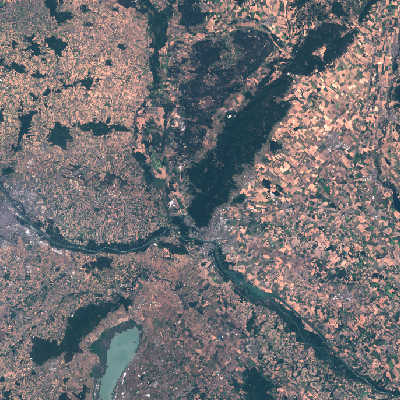

In [ ]:
from IPython import display

url = f'{EE_PUBLIC}/assets/{ASSET_ID}:getPixels'
body = {
    'fileFormat': 'PNG',
    'bandIds': ['B4', 'B3', 'B2'],
    'region': asset['geometry'],
    'grid': {
        'dimensions': {'width': 400, 'height': 400},
    },
    'visualizationOptions': {
        # 'ranges': [{'min': 0, 'max': 3000}],
        'ranges': [{'min': 1200, 'max': 3500}],
    },
}
print('Geometry:', asset['geometry'])
image_response = session.post(url, json=body)
image_content = image_response.content

display.Image(image_content)

# Selecting a region from the image

## A. Calculating the precise tile

The CRS of the image is [EPSG:32633](https://epsg.io/32633) (unit: meter) while the CRS of the point we defined is [EPSG:4326](https://epsg.io/4326) (unit: degree). We did not specified `EPSG:4326` anywhere, the CRS hidden under this code is a World Geodetic System 1984 (WGS84), used in GPS, and it is a common default when working with web applications or APIs.

In [ ]:
import pyproj  # Python interface to PROJ (https://proj.org/)
import shapely.geometry, shapely.ops

# Convert GeoJSON to shapefile geometry.
aoi_shp = shapely.geometry.shape(AOI_JSON)
print('Point in EPSG:4326 (degrees):', aoi_shp.wkt)

# Projection of the "standard" WGS/GPS CRS
WGS_PROJ = pyproj.Proj('EPSG:4326')
# Projection of the CRS of the image
IMG_PROJ = pyproj.Proj('EPSG:32633')

# Define the transformation between two projections:
transformer = pyproj.Transformer.from_proj(WGS_PROJ, IMG_PROJ, always_xy=True)

# Project the point in WGS84 CRS to the CRS of the image.
aoi_imcrs_shp = shapely.ops.transform(transformer.transform, aoi_shp)
print('Point in EPSG:32633 (meters):', aoi_imcrs_shp.wkt)

Point in EPSG:4326 (degrees): POINT (17.073 48.152)
Point in EPSG:32633 (meters): POINT (654178.0331950987 5335272.721626806)


Let's construct the expected vector representation of the tile we want to clip from the image. We will use the AOI point as a centroid of the tile. The CRS is EPSG:32633 so we can safely use distances in meters to calculate the rectangular tile of the size 256 × 256 pixels, which is equal to 2560 × 2560 meters.

Tile in EPSG:32633: POLYGON ((655458.0331950987 5336552.721626806, 655458.0331950987 5333992.721626806, 652898.0331950987 5333992.721626806, 652898.0331950987 5336552.721626806, 655458.0331950987 5336552.721626806))


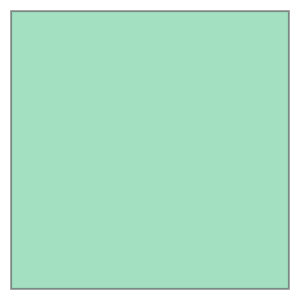

In [ ]:
# Create rectangular polygon (a square) from the AOI in EPSG:32633
tile_size = 256 * 10  # 256 pixels x 10 m resolution
# Top-left corner of tile
xmin = aoi_imcrs_shp.x - tile_size / 2  # same as translate_x
ymin = aoi_imcrs_shp.y + tile_size / 2  # same as translate_y
# Bottom-right corner of the tile
xmax = xmin + tile_size
ymax = ymin - tile_size
# Helper function to generate square from the top-left and bottom-right coords.
tile_imgcrs_shp = shapely.geometry.box(xmin, ymin, xmax, ymax)
print('Tile in EPSG:32633:', tile_imgcrs_shp.wkt)
tile_imgcrs_shp

Finally, transform the tile geometry back from the projection of the image (in meters) back to standard projection (in degrees).

In [ ]:
# Transformation from the image CRS to the WGS84 CRS
transformer = pyproj.Transformer.from_proj(IMG_PROJ, WGS_PROJ, always_xy=True)
wgs_tile_shp = shapely.ops.transform(transformer.transform, tile_imgcrs_shp)

print('Tile in EPSG:32633:', tile_imgcrs_shp.wkt)
print('Tile in EPSG:4326:', wgs_tile_shp.wkt)

Tile in EPSG:32633: POLYGON ((655458.0331950987 5336552.721626806, 655458.0331950987 5333992.721626806, 652898.0331950987 5333992.721626806, 652898.0331950987 5336552.721626806, 655458.0331950987 5336552.721626806))
Tile in EPSG:4326: POLYGON ((17.090666120871887 48.16319681269441, 17.089730976252987 48.14017996918713, 17.05534156035129 48.140800339746924, 17.056261342523673 48.16381768159312, 17.090666120871887 48.16319681269441))


In [ ]:
# Convert the tile from shapefile to GeoJSON
wgs_tile_json = shapely.geometry.mapping(wgs_tile_shp)
print('Tile in EPSG:4326 (GEOJSON):', wgs_tile_json)

# Preview the tile on the map
folium_fig, folium_map = setup_folium(location=MAP_CENTER, zoom=13, width=300, height=300)
folium.Marker(MAP_CENTER, popup='FIIT STU').add_to(folium_map)
folium.GeoJson(wgs_tile_json, name='Tile area').add_to(folium_map)
folium_map.add_child(folium.LayerControl())
folium_fig

Tile in EPSG:4326 (GEOJSON): {'type': 'Polygon', 'coordinates': (((17.090666120871887, 48.16319681269441), (17.089730976252987, 48.14017996918713), (17.05534156035129, 48.140800339746924), (17.056261342523673, 48.16381768159312), (17.090666120871887, 48.16319681269441)),)}


## B. Selecting the region manually

We can simply use the https://geojson.io and select the region with a `Polygon` geometry.

In [ ]:
# Set the region
wgs_tile_json = {"type": "Polygon", "coordinates": [[[17.090666120871887, 48.16319681269441], [17.089730976252987, 48.14017996918713], [17.05534156035129, 48.140800339746924], [17.056261342523673, 48.16381768159312], [17.090666120871887, 48.16319681269441]]]}

# Preview the tile on the map
folium_fig, folium_map = setup_folium(location=MAP_CENTER, zoom=13, width=300, height=300)
folium.Marker(MAP_CENTER, popup='FIIT STU').add_to(folium_map)
folium.GeoJson(wgs_tile_json, name='Tile area').add_to(folium_map)
folium_map.add_child(folium.LayerControl())
folium_fig

# Get a RGB preview of the AOI

Now we should have the correct `region` geometry to clip the tile.

Region: {"type": "Polygon", "coordinates": [[[17.090666120871887, 48.16319681269441], [17.089730976252987, 48.14017996918713], [17.05534156035129, 48.140800339746924], [17.056261342523673, 48.16381768159312], [17.090666120871887, 48.16319681269441]]]}


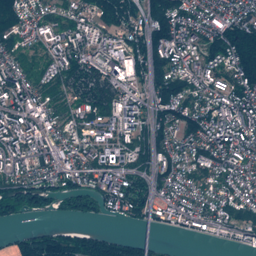

In [ ]:
url = f'{EE_PUBLIC}/assets/{ASSET_ID}:getPixels'
body = {
    'fileFormat': 'PNG',
    'bandIds': ['B4', 'B3', 'B2'],
    'region': wgs_tile_json,
    'grid': {
        'dimensions': {'width': 256, 'height': 256},
    },
    'visualizationOptions': {
        'ranges': [{'min': 1200, 'max': 3500}],
    },
}
print('Region:', json.dumps(wgs_tile_json))
response = session.post(url, json=body)
display.Image(response.content)

# Load the image data with rasterio

There are several options for how to get the image data. The most common is downloading and loading the GeoTIFF with rasterio or GDAL: `data = rasterio.open('path/to/geo.tiff')`. Then we can access the bands via indexes e.g. `band1 = data.read(1); band2 = data.read(2);`. Every band is represented by a 2D NumPy array and each element of this matrix represents a single pixel.

```python
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
```

We are going to request 4 bands, `B2` - Blue, `B3` - Green, `B4` - Red, and `B8` - Near-infrared (NIR):

| Name | Pixel Size | Wavelength                    | Description |
|------|------------|-------------------------------|-------------|
| ...  |            |                               |             |
| B2   | 10 meters  | 496.6nm (S2A) / 492.1nm (S2B) | Blue        |
| B3   | 10 meters  | 560nm (S2A) / 559nm (S2B)     | Green       |
| B4   | 10 meters  | 664.5nm (S2A) / 665nm (S2B)   | Red         |
| ...  |            |                               |             |
| B8   | 10 meters  | 835.1nm (S2A) / 833nm (S2B)   | NIR         |


In [ ]:
import io
import rasterio

url = f'{EE_PUBLIC}/assets/{ASSET_ID}:getPixels'
body = {
    'fileFormat': 'GEO_TIFF',
    'bandIds': ['B2', 'B3', 'B4', 'B8'],
    'region': wgs_tile_json,
    'grid': {
        'dimensions': {'width': 256, 'height': 256},
    },
}
response = session.post(url, json=body)
# Reading in memory data needs bit more massaging:
geotiff = rasterio.MemoryFile(io.BytesIO(response.content)).open()
type(geotiff)

rasterio.io.DatasetReader

## GeoTIFF metadata

Let's print some GeoTIFF metadata:

In [ ]:
print('Size:', f'{geotiff.width} x {geotiff.height}')
print('Number of bands:', geotiff.count)
print('Band indexes:', geotiff.indexes)
print('Bands:', dict(zip(['B2', 'B3', 'B4', 'B8'], geotiff.indexes)))
print('CRS:', geotiff.crs)
print('Affine transformation:', geotiff.transform)

Size: 256 x 256
Number of bands: 4
Band indexes: (1, 2, 3, 4)
Bands: {'B2': 1, 'B3': 2, 'B4': 3, 'B8': 4}
CRS: EPSG:32633
Affine transformation: | 10.00, 0.00, 652898.03|
| 0.00,-10.00, 5336552.72|
| 0.00, 0.00, 1.00|


## GeoTIFF pixels

In [ ]:
# The image is small, so we can preload all the pixels from the bands:
pixels = {
    'B2': geotiff.read(1),
    'B3': geotiff.read(2),
    'B4': geotiff.read(3),
    'B8': geotiff.read(4)
}

# Investigate data in a single band:
print('Band data type:', type(pixels['B2']))
print('Band data shape:', pixels['B2'].shape)
print('Band data:', pixels['B2'])

Band data type: <class 'numpy.ndarray'>
Band data shape: (256, 256)
Band data: [[1902 1907 1906 ... 2286 2294 2230]
 [1905 1907 1898 ... 2250 2128 2079]
 [1899 1912 1909 ... 2287 2126 2102]
 ...
 [2504 2513 2509 ... 2103 2107 2101]
 [2487 2508 2505 ... 2098 2095 2097]
 [2490 2515 2535 ... 2092 2102 2109]]



Finally, let's see how the bands look like...

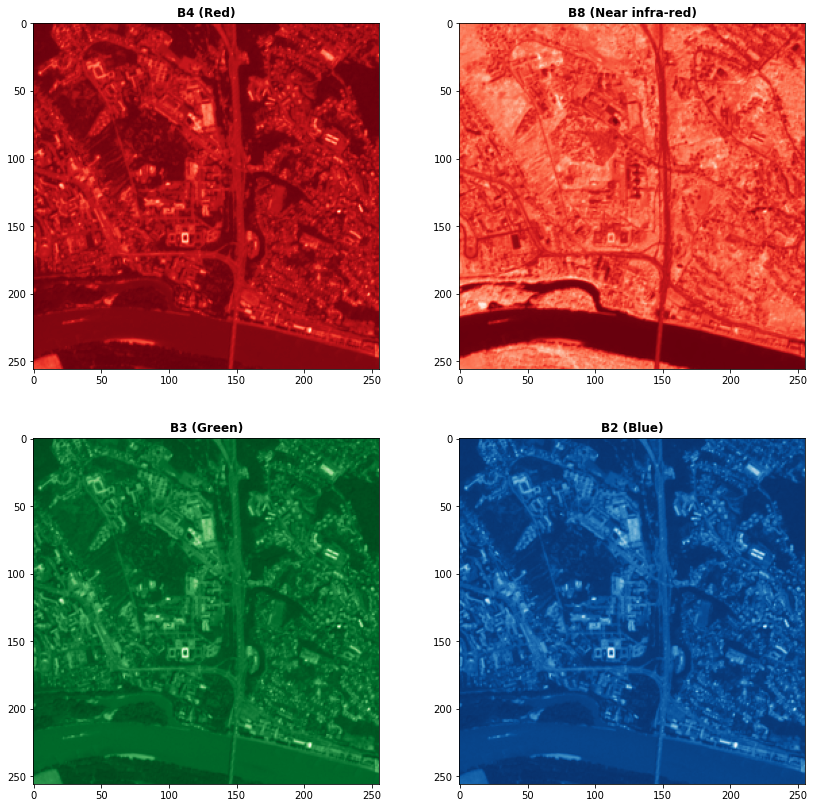

In [ ]:
import rasterio.plot
from matplotlib import pyplot

# 'bandIds': ['B2', 'B3', 'B4', 'B8'],
fig, axes = pyplot.subplots(2, 2, figsize=(14, 14))
ax_iter = axes.flat
rasterio.plot.show(pixels['B4'], ax=next(ax_iter), cmap='Reds_r', title='B4 (Red)')
rasterio.plot.show(pixels['B8'], ax=next(ax_iter), cmap='Reds_r', title='B8 (Near infra-red)')
rasterio.plot.show(pixels['B3'], ax=next(ax_iter), cmap='Greens_r', title='B3 (Green)')
rasterio.plot.show(pixels['B2'], ax=next(ax_iter), cmap='Blues_r', title='B2 (Blue)')

# Land use detection using NDVI and NDWI

Now when we have the right tile, let's assume that we want to categorize the tile according to land use. I.e we want to know how much area is covered by trees and water.

To do that we will start by calculating two well-known indexes from the bands: [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) and [Normalized difference water index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index).

The NDVI can be calculated from the *Red* and *NIR* bands:

$NDVI = \frac{NIR-Red}{NIR+Red}$

The NDWI can be calculated from the *Green* and *NIR* bands:

$NDWI = \frac{Green-NIR}{Green+NIR}$

Because bands are `numpy.ndarray` we use it's vector operations magic and we can easily apply the formulas as we see them in a symbolic form:

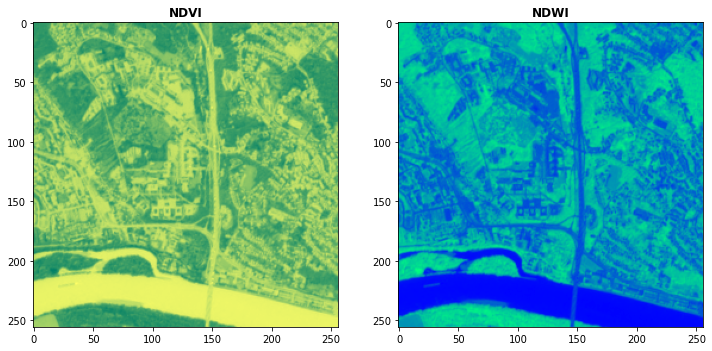

In [ ]:
# Make the band referencing easier
red, green, nir = 'B4', 'B3', 'B8' 

# NDVI = (NIR-RED) / (NIR+RED)
ndvi = (pixels[nir].astype(float) - pixels[red].astype(float)) / (pixels[nir] + pixels[red])

# NDWI = (GREEN-NIR) / (GREEN+NIR)
ndwi = (pixels[green].astype(float) - pixels[nir].astype(float)) / (pixels[nir] + pixels[green])

# Display the results
fig, axes = pyplot.subplots(1, 2, figsize=(12, 6))
ax_iter = axes.flat
rasterio.plot.show(ndvi, ax=next(ax_iter), cmap='summer_r', title='NDVI')
rasterio.plot.show(ndwi, ax=next(ax_iter), cmap='winter_r', title='NDWI')

Let's see how the numbers in NDVI and NDWI look like.


In [ ]:
def print_stats(title, data):
    print(f'{title}:', data.mean(), data.min(), data.max())

print_stats('NDVI', ndvi)
print_stats('NDWI', ndwi)

NDVI: 0.24385543402100238 -0.13303717559036707 0.6183965195773773
NDWI: -0.2092311054714692 -0.5377347348529585 0.18933100131176214


Now we can binarize (i.e. create a binary masks) the indexes with the use of thresholds:

* $NDVI > 0.3$ is considered to be vegetation.
* $NDWI > 0.0 $ is considered to be water.

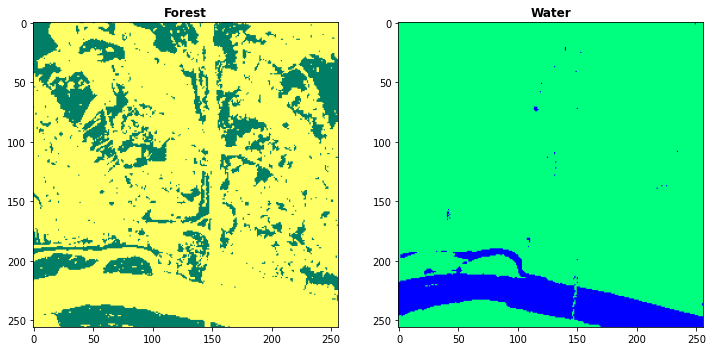

In [ ]:
import numpy as np

# Generate binary mask for the forest.
# The mask will contain only two values:
# 0 - no forest, and 1 - forest
forest_mask = np.zeros(ndvi.shape, dtype=np.uint8)
forest_mask[ndvi > 0.4] = 1

# Generate binary mask for the water.
# The mask will contain only two values:
# 0 - no water, and 1 - water
water_mask = np.zeros(ndvi.shape, dtype=np.uint8)
water_mask[ndwi > 0.0] = 1

# Display the results
fig, axes = pyplot.subplots(1, 2, figsize=(12, 6))
ax_iter = axes.flat
rasterio.plot.show(forest_mask, ax=next(ax_iter), cmap='summer_r', title='Forest')
rasterio.plot.show(water_mask, ax=next(ax_iter), cmap='winter_r', title='Water')

# Land use results with pandas

We can use the binarized masks to calculate the covered area, given that every pixel represents the area of 10 × 10 m.

Once again we will use the `numpy`'s magic to sum the pixels and `pandas` to calculate the area.

In [ ]:
import pandas as pd

# Calculate number of pixels
total_pixels = geotiff.width * geotiff.height
forest_pixels = forest_mask.sum()
water_pixels = water_mask.sum()
other_pixels = total_pixels - forest_pixels - water_pixels

area_df = pd.DataFrame({
    'type': ['Forest', 'Water', 'Other'],
    'pixels': [forest_pixels, water_pixels, other_pixels]
})
area_df['area_m2'] = area_df['pixels'] * 100  # pixel area: 10 * 10 = 100 m2
area_df['area_pct'] = round(area_df['pixels'] / total_pixels * 100, 1)
area_df

,type,pixels,area_m2,area_pct
0,Forest,15003.0,1500300.0,22.9
1,Water,6710.0,671000.0,10.2
2,Other,43823.0,4382300.0,66.9


And finally ... the chart!

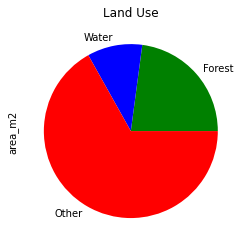

In [ ]:
area_df.set_index('type')['area_m2'].plot(kind='pie', title='Land Use', colors=['g', 'b', 'r'])

# Raster mask vectorization

## Vectorize georeferenced raster with rasterio

Let's assume that we need the water mask also in a vectorized form i.e. in *GeoJSON* or *shapefile* format.

We will use `rasterio.features.shapes` shape generator, which takes a raster and its mask and generates shapes out of it. The generator also accepts an *affine transformation matrix* which translates the shape coordinates to the particular CRS.

Luckily the GeoTIFF already contains the affine transformation as part of its georeferencing metadata:

In [ ]:
print('Affine transformation matrix:', geotiff.transform, sep='\n')

Affine transformation matrix:
| 10.00, 0.00, 652898.03|
| 0.00,-10.00, 5336552.72|
| 0.00, 0.00, 1.00|


Now we can generate the georeferenced shapes from the water raster. After collecting the list of polygons we generate the single shapely geometry object.

Note that we use just a dummy filled raster as a `source`, the shapes are generated only from the `water` raster, which is used as a `mask`.

Number of polygons: 38
Number of polygons after union: 38
Geometry type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


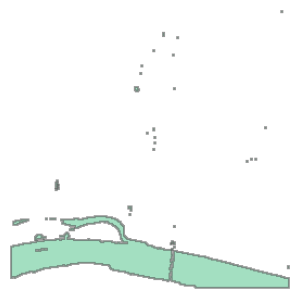

In [ ]:
import numpy as np
import rasterio.features

# Definition of the shape generator
shape_generator = rasterio.features.shapes(
    source=np.full(pixels['B2'].shape, 1).astype('uint8'),
    mask=water_mask,
    transform=geotiff.transform
)

# Collect the polygons from the generator
polygons = []
for p, _ in shape_generator:
    polygon = shapely.geometry.shape(p)
    polygons.append(polygon)

print('Number of polygons:', len(polygons))
water_shp = shapely.ops.unary_union(polygons)
print('Number of polygons after union:', len(water_shp.geoms))
print('Geometry type:', type(water_shp))
water_shp

## Cleanup up and simplify the geometry with shapely

There are a lot of small artficats, which are probably not water. Let's ignore small water areas with the size less then 10 m in any direction - removing and adding `buffer` cleans up the small artifacts. Applying `simplify` reduces the number of coordinates.

Number of polygons after cleanup: 9
Vector water area: 664177
Raster water area: 671000


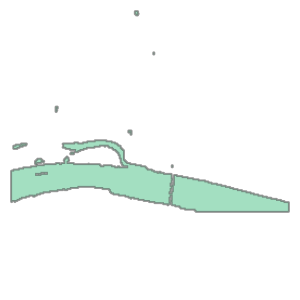

In [ ]:
# Note that coordinates and arguments are in meters as we in EPSG:32633.
# So we subtract 5m buffer, add 5m buffer and then simplify the coordinates with tolerance of 0.5m
water_shp = water_shp.buffer(-5).buffer(5).simplify(0.5)
print('Number of polygons after cleanup:', len(water_shp.geoms))
print('Vector water area:', round(water_shp.area))
print('Raster water area:', round(water_pixels * 100))
water_shp

## Conversion of vectorized mask back to EPSG:4326

We have the result, unfortunately the coordinates are in EPSG:32633, but we want the result in a GPS compatible EPSG:4326:

In [ ]:
# Transformation from the image CRS to the WGS84 CRS
transformer = pyproj.Transformer.from_proj(
    proj_from=pyproj.Proj('EPSG:32633'),
    proj_to=pyproj.Proj('EPSG:4326'),
    always_xy=True,
)

# Convert the geometry between CRS:
wgs_water_shp = shapely.ops.transform(transformer.transform, water_shp)

# Convert from shapefile to GeoJSON
water_json = shapely.geometry.mapping(wgs_water_shp)
print(json.dumps(water_json))

# Display the result in map widget
folium_fig, folium_map = setup_folium(location=MAP_CENTER, zoom=14, width=500, height=500)
folium.Marker(MAP_CENTER, popup='FIIT STU').add_to(folium_map)
folium.GeoJson(water_json, name='Water area').add_to(folium_map)
folium.GeoJson(wgs_tile_json, name='Tile area').add_to(folium_map)
folium_map.add_child(folium.LayerControl())
folium_fig

{"type": "MultiPolygon", "coordinates": [[[[17.055511881102728, 48.14169700020935], [17.05550836950426, 48.14164335007313], [17.055489067450562, 48.14162066083061], [17.05544104589871, 48.14160834330466], [17.055394076101745, 48.14162236028044], [17.0553756722914, 48.1416545008187], [17.055476221969577, 48.14417202731032], [17.055492608551013, 48.144200274191554], [17.055532050843684, 48.14421515199301], [17.055746632084205, 48.14421222882648], [17.055754303590334, 48.144274243930724], [17.055797895055186, 48.14429929857327], [17.056421948768882, 48.144290119259054], [17.05642723432986, 48.144348020196105], [17.056466946897377, 48.144375813506464], [17.056962922284796, 48.144370411034984], [17.056970595283996, 48.14443242603496], [17.056996142055333, 48.14445215861946], [17.05702717131084, 48.14445896827698], [17.05790693311879, 48.144443481829846], [17.057912220369964, 48.14450138267281], [17.05795193384416, 48.14452917545586], [17.058582255711755, 48.14452135946872], [17.058589930687

No we have a vectorized data can easily share the data and preview them e.g. in https://geojson.io.

# Conclusion

This was a basic tutorial of how to work with a satellite imagery. We have shown:
* How to search for the imagery and what are the important filtering options.
* How to load raster image data.
* How to calculate indexes based on raster data.
* How to reproject geometry, i.e. how convert geometry coordinates between different CRS (from degrees to meters and back).
* How to convert raster mask to vector geometry.
* How to reduce raw pixel data to scalar measurements and statistics.

# Ideas for further exploration

* Replace the `AOI_JSON` with another `Point` ot `Polygon` geometry. Use [geojson.io](https://geojson.io) to generate the geometry.
* Use the `region` with a `Polygon` geometry when getting pixels from the API with `getPixels` request, instead of using `affineTransform`.
* Use [COPERNICUS/S2_SR](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) surface reflectance compensated dataset instead of [COPERNICUS/S2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2). Compare difference in `B4`, `B3`, `B2` visualization and the investigate the additional bands.
* Use the `Pillow` package to get the RGB preview from the `B4`, `B3`, `B2` bands instead of using the `getPixels` with [PIL.Image.fromarray](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.fromarray).
* Reproject the `ndvi` and `ndwi` rasters (or the rgb preview) with [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset) and display them in the `folium` widget using the [folium.raster_layers.ImageOverlay](https://python-visualization.github.io/folium/modules.html#folium.raster_layers.ImageOverlay).
* Store the `B4`, `B3`, `B2`, `B8`, `ndvi` and  `ndwi` bands as a geotiff with `rasterio`.
* Install "a free and open source geographic information system" [QGIS](https://www.qgis.org/en/site/) (desktop application). Open the geotiff from the previous task in QGIS.
* Generate a preview for all bands in [COPERNICUS_S1_GRD](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD?hl=en) Synthetic Aperture Radar (SAR) dataset.
* Calculate `forest` data for several images from history during spring or summer (ideally from the same month across several years to diminish the effect of the vegetation seasonality) and calculate the differences between every two pairs (e.g. 2020/07 vs 2021/07, 2021/07 vs 2022/07, ...). Visualize the forest "cuts" and "grows" for every comparison.
* Pick some cloudy image asset e.g. `COPERNICUS/S2/20220810T094601_20220810T094739_T33UXP` and mask the clouds with the use of `probability` band from `COPERNICUS/S2_CLOUD_PROBABILITY` dataset.
* Use Sentinel Hub [EO Browser](https://www.sentinel-hub.com/explore/eobrowser/) to browse through Sentinel 2 data. Switch to `Scene classification map` ([example](https://apps.sentinel-hub.com/eo-browser/?zoom=12&lat=48.16551&lng=17.09713&themeId=MONITORING-NORMAL-MODE&visualizationUrl=https%3A%2F%2Fservices.sentinel-hub.com%2Fogc%2Fwms%2F4e7f012a-5920-47bc-a0f1-7f075152f077&datasetId=S2L2A&fromTime=2022-08-30T00%3A00%3A00.000Z&toTime=2022-08-30T23%3A59%3A59.999Z&layerId=SCENE-CLASSIFICATION&demSource3D=%22MAPZEN%22)).

# Career at SpaceKnow Inc. 🛰

* **Do you find this topic interesting?** 😍
* **Do you want to do satellite image processing full-time on a more advanced level?** 🥇 *(Scalable platform, multiple satellite imagery providers, ML/AI processing, interesting projecs with our partners such as [ESA](https://www.esa.int/) 🇪🇺, ...)*
* **Apply today at https://spaceknow.com/careers/** 🚀

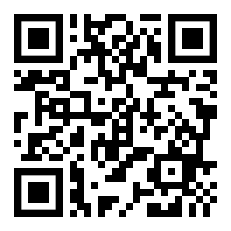